<a href="https://colab.research.google.com/github/pleelapr/data-imputation-hsu/blob/main/DataImputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import pandas as pd
from impyute.imputation.cs import fast_knn
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

import numpy as np

from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
rng = np.random.RandomState(42)

def add_missing_values(df, missing_rate = 0.5):
    n_samples = len(df)
    n_features = len(df.columns) - 1

    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    temp = df.copy().to_numpy()
    temp[missing_samples, missing_features] = np.nan
    df_new = pd.DataFrame(temp, columns = df.columns.values)
    return df_new

In [4]:
N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores

def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()

def get_impute_zero_score(X_missing, y_missing):
    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()

def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()

def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()

def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

In [5]:
raw_data = datasets.fetch_california_housing()
print(raw_data.DESCR)
df_full = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
df_full['target'] = raw_data.target

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
missing_data_percentage = [0.1, 0.25, 0.5, 0.75]

df_list = []

for per in missing_data_percentage:
  df_list.append(add_missing_values(df_full, missing_rate=per))

print(df_list[0].info(show_counts=True))
print(df_list[0].isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20354 non-null  float64
 1   HouseAge    20371 non-null  float64
 2   AveRooms    20391 non-null  float64
 3   AveBedrms   20386 non-null  float64
 4   Population  20401 non-null  float64
 5   AveOccup    20381 non-null  float64
 6   Latitude    20390 non-null  float64
 7   Longitude   20382 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
MedInc        286
HouseAge      269
AveRooms      249
AveBedrms     254
Population    239
AveOccup      259
Latitude      250
Longitude     258
target          0
dtype: int64


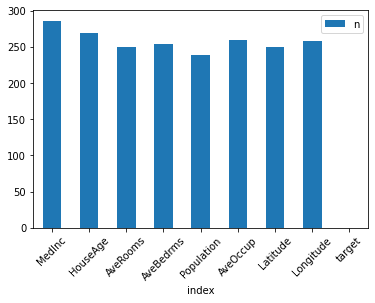

In [7]:
df_list[0].isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=45)

In [20]:
def result_matrix(list_df_with_missing_value):
  x_labels = []
  missing_rates = []
  mses = np.zeros(1 + (len(list_df_with_missing_value) * 4))
  stds = np.zeros(1 + (len(list_df_with_missing_value) * 4))

  x = df_full.loc[:, df_full.columns != 'target'].values
  y = df_full['target'].values

  mses[0], stds[0] = get_full_score(x, y)
  x_labels.append("Full data")
  missing_rates.append("0%")

  count = 1
  for idx, df in enumerate(list_df_with_missing_value):
    missing_x = df.loc[:, df.columns != 'target'].values
    missing_y = df['target'].values

    mses[count], stds[count] = get_impute_zero_score(missing_x, missing_y)
    x_labels.append(f"Zero imputation")
    missing_rates.append(f"{missing_data_percentage[idx]*100}%")
    count += 1

    mses[count], stds[count] = get_impute_knn_score(missing_x, missing_y)
    x_labels.append(f"KNN Imputation")
    missing_rates.append(f"{missing_data_percentage[idx]*100}%")
    count += 1

    mses[count], stds[count] = get_impute_mean(missing_x, missing_y)
    x_labels.append(f"Mean Imputation")
    missing_rates.append(f"{missing_data_percentage[idx]*100}%")
    count += 1

    mses[count], stds[count] = get_impute_iterative(missing_x, missing_y)
    x_labels.append(f"Iterative Imputation")
    missing_rates.append(f"{missing_data_percentage[idx]*100}%")
    count += 1

  mses = mses * -1

  return x_labels, missing_rates, mses, stds

In [40]:
import matplotlib.pyplot as plt

def plot(x_labels, mses_diabetes, stds_diabetes, title_suffix=""):
  n_bars = len(mses_diabetes)
  xval = np.arange(n_bars)

  # plot diabetes results
  plt.figure(figsize=(12, 6))
  ax1 = plt.subplot(121)
  for j in xval:
      ax1.barh(
          j,
          mses_diabetes[j],
          xerr=stds_diabetes[j],
          alpha=0.6,
          align="center",
      )
  if title_suffix == "":
    ax1.set_title(f"Imputation Techniques")
  else:
    ax1.set_title(f"Imputation Techniques : {title_suffix}")
  ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
  ax1.set_yticks(xval)
  ax1.set_xlabel("MSE")
  ax1.invert_yaxis()
  ax1.set_yticklabels(x_labels)

  plt.show()

In [21]:
result = result_matrix(df_list)

In [43]:
df_result = pd.DataFrame({
    'Method': result[0],
    'MissingRate': result[1],
    'MSE': result[2],
    'STD': result[3]
})
df_result_sorted = df_result.sort_values(by=['MSE']).reset_index(drop=True)
df_result_sorted.to_csv('data.csv')
print(df_result_sorted)

                  Method MissingRate       MSE       STD
0              Full data          0%  0.449117  0.096993
1         KNN Imputation       10.0%  0.456493  0.086663
2        Mean Imputation       10.0%  0.461676  0.088798
3         KNN Imputation       25.0%  0.471449  0.081778
4   Iterative Imputation       10.0%  0.474267  0.093785
5        Mean Imputation       25.0%  0.490390  0.094469
6        Zero imputation       10.0%  0.506902  0.095332
7         KNN Imputation       50.0%  0.509174  0.097872
8   Iterative Imputation       25.0%  0.517630  0.090707
9         KNN Imputation       75.0%  0.525631  0.104719
10       Mean Imputation       50.0%  0.536914  0.103594
11       Zero imputation       25.0%  0.539435  0.107077
12       Zero imputation       50.0%  0.539486  0.113868
13       Zero imputation       75.0%  0.540279  0.111688
14       Mean Imputation       75.0%  0.546973  0.105663
15  Iterative Imputation       50.0%  0.555950  0.096016
16  Iterative Imputation       

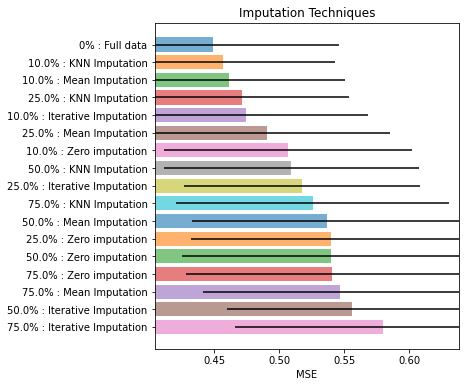

In [26]:
plot(["{} : {}".format(b_, a_) for a_, b_ in zip(df_result_sorted['Method'], df_result_sorted['MissingRate'])], df_result_sorted['MSE'], df_result_sorted['STD'])

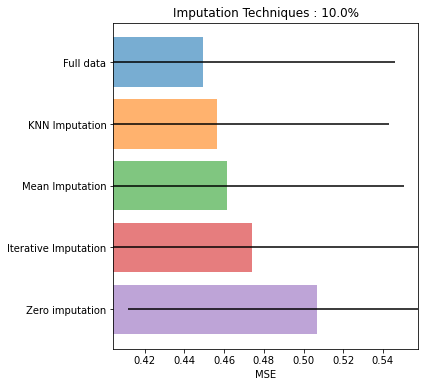

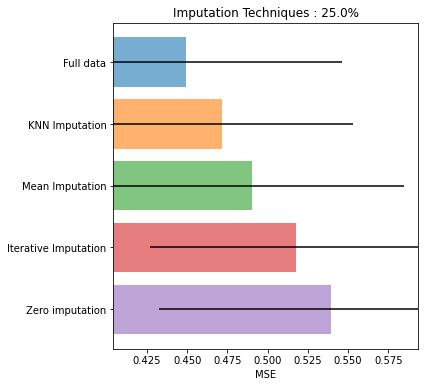

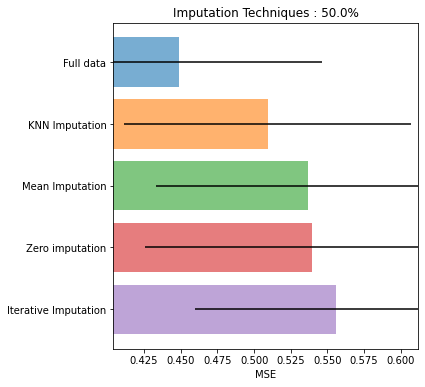

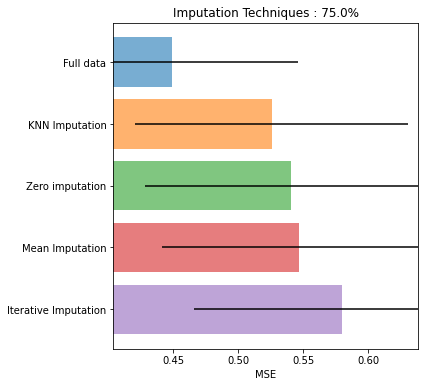

In [41]:
percentage_list = df_result_sorted['MissingRate'].unique()
for per in percentage_list:
  if per == '0%':
    continue
  temp = df_result_sorted.loc[(df_result_sorted['MissingRate'] == per) | (df_result_sorted['MissingRate'] == '0%')].reset_index(drop=True)
  # print(temp)
  plot(temp['Method'], temp['MSE'], temp['STD'], per)